In [112]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
import pickle
import os
import time
import datetime
from matplotlib import patches
import multi_tracker_analysis as mta
import scipy.stats
import figurefirst as fifi
import pandas
import copy
import matplotlib.patches as mpatches

from numpy import random, histogram2d, diff
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from scipy.interpolate import interp1d

import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy.stats
import scipy.optimize

import flystat # for bootstrapping 95% conf. intervals

# Load and Transform the Data

In [113]:
def load_data():
    df = pandas.read_hdf('data/flydata_20210428_3cam.hdf', 'flydata_20210428_3cam')


    minimum_req_visits = 3
    flids_okay = []
    for flid in df.flid.unique():
        dfq = df[df.flid==flid]
        if len(dfq) >= minimum_req_visits:
            flids_okay.append(flid)
    df = df[df.flid.isin(flids_okay)]

    df.fraction_of_time_near_odor += 1e-4 # to help with logs

    # spatial novelty
    new_camera = []
    for ix in range(len(df)):
        nc = 1
        try:
            if df.iloc[ix].flid == df.iloc[ix-1].flid:
                if df.iloc[ix].camera != df.iloc[ix-1].camera:
                    nc = 2
            else:
                nc = 2
        except:
            nc = 2 # first one
        new_camera.append(nc)
    df['new_camera'] = new_camera

    # nth visit
    nth_visit = [1]
    for ix in range(1, len(df)):
        if df.iloc[ix].flid == df.iloc[ix-1].flid:
            nth_visit.append(nth_visit[-1]+1)
        else:
            nth_visit.append(1)
    df['nth_visit'] = nth_visit
    df['log_nth_visit'] = np.log(nth_visit)

    df['mean_interval'] = np.nanmean([df['interval'].values, df['interval2'].values], axis=0)
    df['approached_odor'] = np.sign(df['fraction_of_time_near_odor']-0.001)

    df['camera_num'] = (df['camera'] == 'center_camera')
    df['camera_num'] = (df['camera_num'] -1) /2

    return df

In [114]:
def normalize_data(df):
    df_norm = copy.copy(df)
    normalization_transform_scale = pandas.DataFrame()
    
    for key in df.keys():
        try:
            scale = np.std(df[key])
            norm = df[key] / scale
            normalization_transform_scale[key] = [scale]
        except:
            print('Cannot normalize: ' + key)
            norm = df[key]
            normalization_transform_scale[key] = 1
        df_norm[key] = norm
        
    df_norm['flid'] = df['flid']
    return df_norm, normalization_transform_scale

In [115]:
df = load_data()
df = df[ ~ (df.nth_visit==1) ] # drop the first visits for this analysis
df = df[df.interval > 0] # there is one encoutner with a negative interval (and must therefore be mislabelled)

##### Log transform most of the data, and scale std dev to be unity

In [116]:
trans_df = pandas.DataFrame()
trans_df['flid'] = df.flid

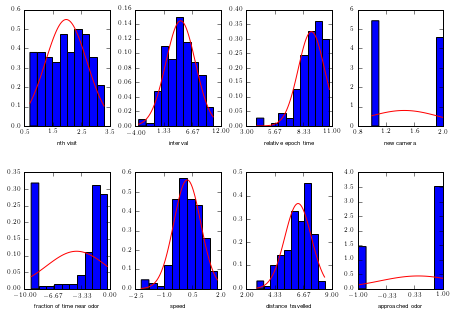

In [117]:
output = 'distance_travelled'
inputs = ['nth_visit',
          'interval',
          'relative_epoch_time',
          'new_camera',
          'fraction_of_time_near_odor', # fraction_of_time_near_odor or approached_odor
          'speed'] # or fraction_of_time_stopped

keys = np.hstack((inputs, output, 'approached_odor'))

fig = plt.figure(figsize=(7.5,5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

for i, key in enumerate(keys):
    ax = fig.add_subplot(2,np.ceil(len(keys)/2.),i+1)
    if key in ['distance_travelled', 'nth_visit', 'interval', 'relative_epoch_time', 'fraction_of_time_near_odor', 'speed']:
        trans_df[key] = np.log(df[key])
    else:
        trans_df[key] = df[key]
        
    ax.hist(trans_df[key], normed=True)
    rv = scipy.stats.norm(np.mean(trans_df[key]), np.std(trans_df[key]))
    x = np.linspace(np.min(trans_df[key]),np.max(trans_df[key]),100)
    pdf = rv.pdf(x)
    ax.plot(x, pdf, color='red')
        
    ax.set_xlabel( key.replace('_', ' ') )
    ax.set_xticks(np.round(np.linspace(ax.get_xticks()[0], ax.get_xticks()[-1], 4), 2))
    
trans_df_norm, normalization_transform_scale = normalize_data(trans_df)
trans_df_norm.reset_index(inplace = True)
    
fifi.mpl_functions.set_fontsize(ax, 6)
fig.savefig('sup_fig_data_log_transform.png', dpi=300)

# Linear Mixed Effects Model

Different (random) intercept for each fly, to account for potential "individuality" of each fly.

https://www.statsmodels.org/devel/examples/notebooks/generated/mixed_lm_example.html

##### The model

In [101]:
model = 'distance_travelled ~  '
for input in inputs: 
    model += ' + ' + input
print('Model: ')
print(model)

Model: 
distance_travelled ~   + nth_visit + interval + relative_epoch_time + new_camera + fraction_of_time_near_odor + speed


##### Fit the model

In [102]:
md = smf.mixedlm(model, trans_df_norm, groups=trans_df_norm["flid"])
mdf = md.fit()
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  distance_travelled
No. Observations:    162      Method:              REML              
No. Groups:          16       Scale:               0.5459            
Min. group size:     2        Likelihood:          -197.3254         
Max. group size:     26       Converged:           Yes               
Mean group size:     10.1                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   7.213    0.608 11.867 0.000  6.022  8.405
nth_visit                   0.007    0.105  0.064 0.949 -0.198  0.212
interval                    0.227    0.071  3.220 0.001  0.089  0.366
relative_epoch_time        -0.188    0.107 -1.755 0.079 -0.397  0.022
new_camera                  0.045   

# Variance Explained ($R^2$)

Traditional $R^2$ for a (generalized) linear model is defined as the fraction of variance that is explained by the model:
$$
R^2 = \frac{\sum \big(\bar{y} - \hat{y_i}\big)^2}{\sum \big(y_i-\bar{y}\big)^2}
$$

where $y_i$ is an actual individual outcome, $\hat{y_i}$ is the model-predicted outcome that goes with it, and  $\bar{y}$ is the average of all the outcomes.


But for a mixed effects model, we have both the fixed effects (equivalent to the linear model) and random effects (e.g. random intercepts for each individual). We can define two different $R^2$ values:

* Conditional $R^2$: is the proportion of total variance explained through both fixed and random effects.
* Marginal $R^2$: is the proportion of total variance explained only by the fixed effects. 

See: https://www.theanalysisfactor.com/r-squared-for-mixed-effects-models/ and the associated reference mentioned there. 

In [103]:
# Get the predictions from the model
# Using either only the fixed effects (one intercept)
# OR back out the intercept for each individual

def get_intercept_for_individual_fly(df, mdf, flid):
    dfq = df.query('flid == ' + str(flid))
    
    pred = 0
    for key in mdf.params.keys():
        if key in ['Intercept', 'groups RE']:
            continue
        else:
            pred += mdf.params[key]*dfq[key].values

    intercept = -np.mean(pred - (-(mdf.resid.values[dfq.index.values] - dfq.distance_travelled.values)))
    
    return intercept

def get_predictions_global(df, mdf, leave_out_key=''):
    predictions = 0
    for key in mdf.params.keys():
        if key in ['Intercept', 'groups RE', leave_out_key]:
            continue
        else:
            predictions += mdf.params[key]*df[key].values
    predictions += mdf.params['Intercept']
    return predictions

def get_predictions_individual(df, mdf, leave_out_key=''):
    predictions = []
    
    for flid in df.flid.unique():
        dfq = df.query('flid == ' + str(flid))
        intercept = get_intercept_for_individual_fly(df, mdf, flid)
        pred = 0
        for key in mdf.params.keys():
            if key in ['Intercept', 'groups RE', leave_out_key]:
                continue
            else:
                pred += mdf.params[key]*dfq[key].values
        predictions = np.hstack((predictions, pred+ intercept)) 
    
    return predictions

In [104]:
# predictions
predictions_fixed = get_predictions_global(trans_df_norm, mdf)
predictions_fixed_and_random = get_predictions_individual(trans_df_norm, mdf)

In [105]:
# residuals
standardized_residuals_fixed = (trans_df_norm.distance_travelled.values - predictions_fixed) / np.std(predictions_fixed)
standardized_residuals_fixed_and_random = (trans_df_norm.distance_travelled.values - predictions_fixed_and_random) / np.std(predictions_fixed_and_random)

In [106]:
y_bar = np.mean(trans_df_norm.distance_travelled.values)
y_i = trans_df_norm.distance_travelled.values
y_hat = predictions_fixed

rsq = sum((y_bar - y_hat)**2) / sum((y_i-y_bar)**2)

print("Marginal R^2 = " + str(rsq))
print("This takes into account ONLY fixed effects.")

Marginal R^2 = 0.4116581599624789
This takes into account ONLY fixed effects.


In [107]:
y_bar = np.mean(trans_df_norm.distance_travelled.values)
y_i = trans_df_norm.distance_travelled.values
y_hat = predictions_fixed_and_random

rsq = sum((y_bar - y_hat)**2) / sum((y_i-y_bar)**2)

print("Conditional R^2 = " + str(rsq))
print("This takes into account both the fixed AND random effects.")

Conditional R^2 = 0.44905718933732236
This takes into account both the fixed AND random effects.


# Diagnostic plots

Let's check that the assumptions of the model have not been violated. Specifically, we look to see:
* the residuals are well distributed (standardized residuals vs predicted)
* the residuals follow a normal distribution (shapiro-wilks test) since we are using a linear model, not generalized
* check the heteroscedasticity (Q-Q plot)
* the variance is not a function of the output (observed vs predicted)

As with the $R^2$ situation, we will look at predictions and residuals that include the fixed and random effects, or only the fixed, since we are using a mixed effects linear model.

Some useful stuff:

https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/



##### Actual vs Predicted

The scatter data should fall evenly around the red line, without any major patterns.

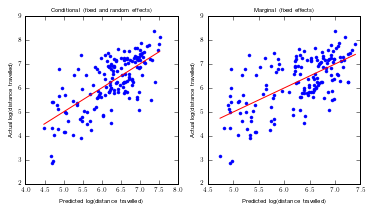

In [108]:
fig = plt.figure(figsize=(6,3))

ax = fig.add_subplot(121)
s = normalization_transform_scale['distance_travelled'].values[0]
ax.plot(predictions_fixed_and_random*s, trans_df_norm.distance_travelled.values*s, '.')
ax.set_xlabel('Predicted log(distance travelled)')
ax.set_ylabel('Actual log(distance travelled)')
x = np.linspace( np.min(predictions_fixed_and_random)*s, np.max(predictions_fixed_and_random)*s, 100)
ax.plot(x,x, color='red')
ax.set_title('Conditional (fixed and random effects)')

ax = fig.add_subplot(122)
ax.plot(predictions_fixed*s, trans_df_norm.distance_travelled.values*s, '.')
ax.set_xlabel('Predicted log(distance travelled)')
ax.set_ylabel('Actual log(distance travelled)')
x = np.linspace( np.min(predictions_fixed)*s, np.max(predictions_fixed)*s, 100)
ax.plot(x,x, color='red')
ax.set_title('Marginal (fixed effects)')

fifi.mpl_functions.set_fontsize(ax, 6)
fig.savefig('supp_fig_actual_vs_predicted.png', dpi=300)

##### Standardized residuals

Standardized residuals = (observed - expected) / std_dev(expected)

The scatter should be evenly distributed around the red line, without any obvious patterns, like growing or shrinking residuals as a function of predicted value.

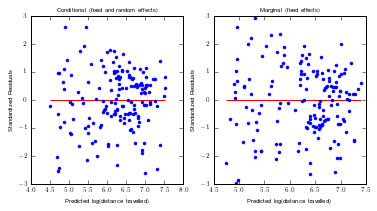

In [109]:
fig = plt.figure(figsize=(6,3))

ax = fig.add_subplot(121)
standardized_residuals = (trans_df_norm.distance_travelled.values - predictions_fixed_and_random) / np.std(predictions_fixed_and_random)
ax.plot(predictions_fixed_and_random*s, standardized_residuals, '.')
ax.hlines(0, np.min(predictions_fixed_and_random*s), np.max(predictions_fixed_and_random*s), colors='red')
ax.set_xlabel('Predicted log(distance travelled)')
ax.set_ylabel('Standardized Residuals')
ax.set_title('Conditional (fixed and random effects)')


ax = fig.add_subplot(122)
standardized_residuals = (trans_df_norm.distance_travelled.values - predictions_fixed) / np.std(predictions_fixed)
ax.plot(predictions_fixed*s, standardized_residuals, '.')
ax.hlines(0, np.min(predictions_fixed*s), np.max(predictions_fixed*s), colors='red')
ax.set_xlabel('Predicted log(distance travelled)')
ax.set_ylabel('Standardized Residuals')
ax.set_title('Marginal (fixed effects)')

fifi.mpl_functions.set_fontsize(ax, 6)
fig.savefig('supp_fig_standardized_residuals.png', dpi=300)

##### Q-Q plot

The scatter should follow the red line, especially in the middle. Looks pretty good here.

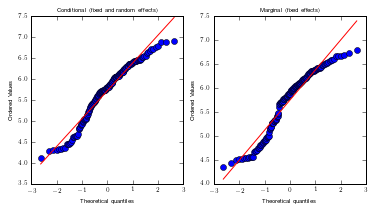

In [110]:
fig = plt.figure(figsize=(6,3))

ax = fig.add_subplot(121)
res = scipy.stats.probplot(predictions_fixed_and_random, plot=ax)
ax.set_title('Conditional (fixed and random effects)')


ax = fig.add_subplot(122)
res = scipy.stats.probplot(predictions_fixed, plot=ax)
ax.set_title('Marginal (fixed effects)')

fifi.mpl_functions.set_fontsize(ax, 6)
fig.savefig('supp_fig_qq.png', dpi=300)

##### Normality of residuals

The residuals should be normally distributed in this case, because we are using a linear model that assumes that the residuals are going to be normally distributed. 

Not ideal here, there seem to be more small residuals than a normal distribution would predict. 

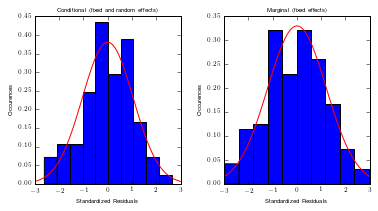

In [111]:
fig = plt.figure(figsize=(6,3))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

ax = fig.add_subplot(121)
standardized_residuals = (trans_df_norm.distance_travelled.values - predictions_fixed_and_random) / np.std(predictions_fixed_and_random)
ax.hist(standardized_residuals, normed=True)

rv = scipy.stats.norm(0, np.std(standardized_residuals))
x = np.linspace(-3,3,100)
pdf = rv.pdf(x)
ax.plot(x, pdf, color='red')
ax.set_xlabel('Standardized Residuals')
ax.set_ylabel('Occurences')
ax.set_title('Conditional (fixed and random effects)')



ax = fig.add_subplot(122)
standardized_residuals = (trans_df_norm.distance_travelled.values - predictions_fixed) / np.std(predictions_fixed)
ax.hist(standardized_residuals, normed=True)

rv = scipy.stats.norm(0, np.std(standardized_residuals))
x = np.linspace(-3,3,100)
pdf = rv.pdf(x)
ax.plot(x, pdf, color='red')
ax.set_xlabel('Standardized Residuals')
ax.set_ylabel('Occurences')
ax.set_title('Marginal (fixed effects)')

fifi.mpl_functions.set_fontsize(ax, 6)
fig.savefig('supp_fig_normal.png', dpi=300)

##### Heteroskedacity: Bresuch-Pagan test

In [55]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

#perform Bresuch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(mdf.resid, mdf.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 20.21769148430009),
 ('p-value', 0.002532777214750738),
 ('f-value', 3.6837484790042363),
 ('f p-value', 0.0018927595101268077)]

In [56]:
def get_predictions_global(df, normalization_transform_scale, 
                                       mdf, leave_out_key='', 
                                       confidence_slope='mean', confidence_intercept='mean'):
    '''
    df -- the original, not transformed/scaled, dataframe
    '''
    
    RHS = 0

    inputs = mdf.params.keys()
    for input in inputs:
        if input in ['Intercept', 'groups RE', leave_out_key]:
            continue
        else:
            std_i = normalization_transform_scale[input].values[0]
            RHS += (mdf.params[input]*df[input].values / std_i)
    
    std_o = normalization_transform_scale[output].values[0]

    dpower_pred = copy.copy(RHS*np.std(df.distance_travelled.values))
    dpower_pred -= np.mean(dpower_pred)
    dpower_pred += np.mean(df.distance_travelled.values)
        
    d_pred = dpower_pred
    
    return copy.copy(d_pred)

##### Observed vs Predicted in log(original coordinate space)

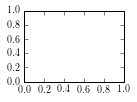

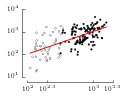

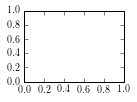

In [57]:
#fig = plt.figure()
#ax = fig.add_subplot(111)
fififig = 'figures/foraging_fig_2_revision.svg'
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, 
                                       make_mplfigures=True, hide_layers=[])
ax = layout.axes[('model', 'model')]
    
    
logd_pred = get_predictions_global(trans_df, normalization_transform_scale, mdf)

#ax.plot(logd_pred, np.log(df.distance_travelled.values), '.')

ax.scatter(logd_pred, (trans_df.distance_travelled.values), c=trans_df.approached_odor, cmap='bone_r', 
               s=3, linewidth=0.25,rasterized=True)

x = np.linspace( np.min(logd_pred), np.max(logd_pred), 100)
ax.plot(x,x, color='red')


yticks = [10**1, 10**2, 10**3, 10**4]
yticklabels = ['$10^1$', '$10^2$', '$10^3$', '$10^4$']

xticks = [10**2, 10**2.3, 10**3, 10**3.3]
xticklabels = ['$10^2$', '$10^{2.3}$', '$10^3$', '$10^{3.3}$']


fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 yticks=np.log(yticks), 
                                 xticks=np.log(xticks),
                                 linewidth=0.5, tick_length=2.5, 
                                 spine_locations={'left': 2.5, 'bottom': 2.5})
ax.set_yticklabels(yticklabels)
ax.set_xticklabels(xticklabels)
ax.minorticks_off()

#ax.set_xlabel('Predicted distance travelled (mm)')
#ax.set_ylabel('Observed distance travelled (mm)')

fifi.mpl_functions.set_fontsize(ax.figure, 6)
layout.append_figure_to_layer(layout.figures['model'], 'model', cleartarget=True)
layout.write_svg(fififig)

##### Isolating effect of interval

First use all the other inputs to calculate predicted distance travelled, then find the residuals, these residuals should be explained by the remining input. 

                            OLS Regression Results                            
Dep. Variable:     distance_travelled   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     18.55
Date:                Mon, 10 May 2021   Prob (F-statistic):           2.88e-05
Time:                        12:48:01   Log-Likelihood:                -202.12
No. Observations:                 162   AIC:                             408.2
Df Residuals:                     160   BIC:                             414.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7643      0.127     45.447      0.0

2.8778234112488176e-05

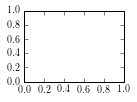

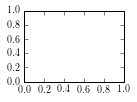

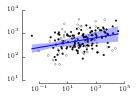

In [58]:
fififig = 'figures/foraging_fig_2_revision.svg'
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, 
                                       make_mplfigures=True, hide_layers=[])
ax = layout.axes[('distance_v_interval', 'distance_v_interval')]

# For given input, use full mixed effects model to remove correlations except this one
input = 'interval'
logd_pred = get_predictions_global(trans_df, normalization_transform_scale, mdf,
                                              leave_out_key=input)
residuals = (trans_df.distance_travelled.values) - logd_pred
md = np.mean(trans_df.distance_travelled.values)
residuals += md

log_df = pandas.DataFrame()
log_df['interval'] = np.log(df.interval.values)
log_df['distance_travelled'] = residuals
log_df['approached_odor'] = df.approached_odor.values
log_df['flid'] = df.flid.values


ax.scatter(log_df.interval.values, log_df.distance_travelled.values, c=df.approached_odor, cmap='bone_r', 
               s=3, linewidth=0.25,rasterized=True)


# Rerun and OLS on just this input
md = smf.ols('distance_travelled ~ interval', log_df)
mdf2 = md.fit()
print(mdf2.summary())


x = np.linspace(np.min(log_df.interval.values), np.max(log_df.interval.values), 100)
y = mdf2.params['interval']*x + mdf2.params['Intercept']
ax.plot(x, y, color='blue')


if 1:
    # show the confidence interval around the slope and mean
    conf95 = mdf2.conf_int(alpha=0.05, cols=None)
    input_coeff_conf_lo = conf95[0][input]
    input_coeff_conf_hi = conf95[1][input]
    
    intercept_conf_lo = conf95[0]['Intercept']
    intercept_conf_hi = conf95[1]['Intercept']
    
    y_hi_hi = input_coeff_conf_hi*x + intercept_conf_hi
    y_hi_lo = input_coeff_conf_hi*x + intercept_conf_lo
    y_lo_hi = input_coeff_conf_lo*x + intercept_conf_hi
    y_lo_lo = input_coeff_conf_lo*x + intercept_conf_lo
    
    y = np.vstack([y_hi_hi, y_hi_lo, y_lo_hi, y_lo_lo])
    y = np.sort(y, axis=0)
    
    ax.fill_between(x, y[0,:], y[-1,:], facecolor='blue', edgecolor='none', alpha=0.3)
    
    
    
yticks = [10**1, 10**2, 10**3, 10**4]
yticklabels = ['$10^1$', '$10^2$', '$10^3$', '$10^4$']

xticks = [10**-1, 10**1, 10**3, 10**5]
xticklabels = ['$10^{-1}$', '$10^1$', '$10^3$', '$10^5$']

fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 yticks=np.log(yticks), 
                                 xticks=np.log(xticks),
                                 linewidth=0.5, tick_length=2.5, 
                                 spine_locations={'left': 2.5, 'bottom': 2.5})
ax.set_yticklabels(yticklabels)
ax.set_xticklabels(xticklabels)
ax.minorticks_off()
ax.set_xlim(np.log(10**-2), np.log(10**5))

#fifi.mpl_functions.set_fontsize(ax, 8)
#ax.set_xlabel('Interval before landing (sec)')
#ax.set_ylabel('Observed distance travelled$^{*}$ (mm)')

fifi.mpl_functions.set_fontsize(ax.figure, 6)
layout.append_figure_to_layer(layout.figures['distance_v_interval'], 'distance_v_interval', cleartarget=True)
layout.write_svg(fififig)

mdf2.pvalues['interval']



In [59]:
# Save data for Fig. 4

log_df_save = pandas.DataFrame()
log_df_save['interval'] = np.log(df.interval.values)
log_df_save['distance_travelled'] = np.log(df.distance_travelled.values)
log_df_save['distance_travelled_residuals_controlled_for_odor_approach'] = residuals
log_df_save['approached_odor'] = df.approached_odor.values
log_df_save['flid'] = df.flid.values

                            OLS Regression Results                            
Dep. Variable:     distance_travelled   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     71.21
Date:                Mon, 10 May 2021   Prob (F-statistic):           1.81e-14
Time:                        12:48:20   Log-Likelihood:                -202.28
No. Observations:                 162   AIC:                             408.6
Df Residuals:                     160   BIC:                             414.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

1.8137978831602427e-14

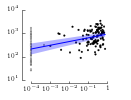

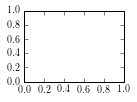

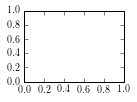

In [61]:
fififig = 'figures/foraging_fig_2_revision.svg'
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, 
                                       make_mplfigures=True, hide_layers=[])
ax = layout.axes[('distance_v_odor', 'distance_v_odor')]

# For given input, use full mixed effects model to remove correlations except this one
input = 'fraction_of_time_near_odor'
logd_pred = get_predictions_global(trans_df, normalization_transform_scale, mdf,
                                              leave_out_key=input)
residuals = np.log(df.distance_travelled.values) - logd_pred
md = np.mean(np.log(df.distance_travelled.values))
residuals += md

log_df = pandas.DataFrame()
log_df[input] = np.log(df[input].values)
log_df['distance_travelled'] = residuals


ax.scatter(log_df[input].values, log_df.distance_travelled.values, c=df.approached_odor, cmap='bone_r', 
               s=3, linewidth=0.25,rasterized=True)


# Rerun and OLS on just this input
md = smf.ols('distance_travelled ~ ' + input, log_df)
mdf3 = md.fit()
print(mdf3.summary())


x = np.linspace(np.min(log_df[input].values), np.max(log_df[input].values), 100)
y = mdf3.params[input]*x + mdf3.params['Intercept']
ax.plot(x, y, color='blue')


if 1:
    # show the confidence interval around the slope and mean
    conf95 = mdf3.conf_int(alpha=0.05, cols=None)
    input_coeff_conf_lo = conf95[0][input]
    input_coeff_conf_hi = conf95[1][input]
    
    intercept_conf_lo = conf95[0]['Intercept']
    intercept_conf_hi = conf95[1]['Intercept']
    
    y_hi_hi = input_coeff_conf_hi*x + intercept_conf_hi
    y_hi_lo = input_coeff_conf_hi*x + intercept_conf_lo
    y_lo_hi = input_coeff_conf_lo*x + intercept_conf_hi
    y_lo_lo = input_coeff_conf_lo*x + intercept_conf_lo
    
    y = np.vstack([y_hi_hi, y_hi_lo, y_lo_hi, y_lo_lo])
    y = np.sort(y, axis=0)
    
    ax.fill_between(x, y[0,:], y[-1,:], facecolor='blue', edgecolor='none', alpha=0.3)
    
    
yticks = [10**1, 10**2, 10**3, 10**4]
yticklabels = ['$10^1$', '$10^2$', '$10^3$', '$10^4$']

xticks = [1e-4, 1e-3, 0.01, 0.1, 1]
xticklabels = ['$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$1$']


fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 yticks=np.log(yticks), 
                                 xticks=np.log(xticks),
                                 linewidth=0.5, tick_length=2.5, 
                                 spine_locations={'left': 2.5, 'bottom': 2.5})
ax.set_yticklabels(yticklabels)
ax.set_xticklabels(xticklabels)
ax.minorticks_off()

#fifi.mpl_functions.set_fontsize(ax, 8)
#ax.set_xlabel('Fraction of time near odor')
#ax.set_ylabel('Observed distance travelled$^{*}$ (mm)')

fifi.mpl_functions.set_fontsize(ax.figure, 6)
layout.append_figure_to_layer(layout.figures['distance_v_odor'], 'distance_v_odor', cleartarget=True)
layout.write_svg(fififig)

mdf3.pvalues['fraction_of_time_near_odor']

In [62]:
log_df_save['distance_travelled_residuals_controlled_for_interval'] = residuals

In [63]:
interval_vs_distance_data_and_model = {'log_df': log_df_save,
                                       'notes': 'log_df contains distance_travelled data that has had the correlation with fraction of time spend neat odor removed',
                                       'distance_travelled_vs_interval': mdf2,
                                       'distance_travelled_vs_approach_odor': mdf3}
f = open('interval_vs_distance_data_and_model.pickle', 'wb')
pickle.dump(interval_vs_distance_data_and_model, f)
f.close()

# Removing heteroskedacity with box cox

In [81]:
df = load_data()
df = df[ ~ (df.nth_visit==1) ] # drop the first visits for this analysis
df = df[df.interval > 0] # there is one encoutner with a negative interval

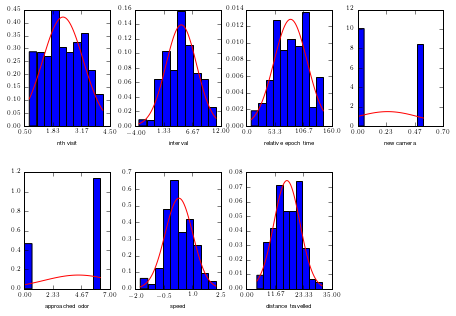

In [82]:
trans_df = pandas.DataFrame()
trans_df['flid'] = df.flid

output = 'distance_travelled'
inputs = ['nth_visit',
          'interval',
          'relative_epoch_time',
          'new_camera',
          'approached_odor',#'fraction_of_time_near_odor', # fraction_of_time_near_odor or approached_odor
          'speed'] # or fraction_of_time_stopped

keys = np.hstack((inputs, output))

fig = plt.figure(figsize=(7.5,5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

for i, key in enumerate(keys):
    ax = fig.add_subplot(2,np.ceil(len(keys)/2.),i+1)
    
    if 0:
        if key in ['distance_travelled', 'nth_visit', 'interval', 'relative_epoch_time', 'fraction_of_time_near_odor', 'speed']:
            trans_df[key] = np.log(df[key])
        else:
            trans_df[key] = df[key]
    else:
        if key == 'approached_odor':
            df[key] += 2
        trans_df[key] = scipy.stats.boxcox(df[key].values)[0]
        
        
    ax.hist(trans_df[key], normed=True)
    rv = scipy.stats.norm(np.mean(trans_df[key]), np.std(trans_df[key]))
    x = np.linspace(np.min(trans_df[key]),np.max(trans_df[key]),100)
    pdf = rv.pdf(x)
    ax.plot(x, pdf, color='red')
        
        
    ax.set_xlabel( key.replace('_', ' ') )
    
    ax.set_xticks(np.round(np.linspace(ax.get_xticks()[0], ax.get_xticks()[-1], 4), 2))
    
    
trans_df_norm, normalization_transform_scale = normalize_data(trans_df)
trans_df_norm.reset_index(inplace = True)
    
fifi.mpl_functions.set_fontsize(ax, 6)
#fig.savefig('sup_fig_data_log_transform.pdf', dpi=300)

In [83]:
model = 'distance_travelled ~  '
for input in inputs: 
    model += ' + ' + input
print('Model: ')
print(model)


md = smf.mixedlm(model, trans_df_norm, groups=trans_df_norm["flid"])
mdf = md.fit()
print(mdf.summary())

Model: 
distance_travelled ~   + nth_visit + interval + relative_epoch_time + new_camera + approached_odor + speed
              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_travelled
No. Observations: 162     Method:             REML              
No. Groups:       16      Scale:              0.5826            
Min. group size:  2       Likelihood:         -202.6687         
Max. group size:  26      Converged:          Yes               
Mean group size:  10.1                                          
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              2.520    0.258  9.782 0.000  2.015  3.024
nth_visit             -0.100    0.119 -0.838 0.402 -0.333  0.134
interval               0.216    0.074  2.922 0.003  0.071  0.362
relative_epoch_time   -0.114    0.128 -0.891 0.373 -0

In [84]:
#perform Bresuch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(mdf.resid, mdf.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 11.34131885871996),
 ('p-value', 0.07838325992903089),
 ('f-value', 1.944687609751388),
 ('f p-value', 0.07695059469136777)]